# Imports

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, log_loss, accuracy_score

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from keras.models import Sequential
from keras.layers import Dense,Flatten,GlobalAveragePooling2D,Conv2D,MaxPooling2D,Activation,Dropout


import warnings


from art.estimators.classification import KerasClassifier
from art.attacks.evasion import FastGradientMethod, CarliniLInfMethod, DeepFool, ProjectedGradientDescent
from art.attacks.evasion import FeatureAdversariesTensorFlowV2
from art.estimators.classification import TensorFlowV2Classifier
warnings.filterwarnings('ignore')
if tf.__version__[0] != '2':
    raise ImportError('This notebook requires TensorFlow v2.')
tf.compat.v1.disable_eager_execution()

In [ ]:
lfw_dataset=fetch_lfw_people(min_faces_per_person=100)

print(lfw_dataset.images.shape)
print(lfw_dataset.data.shape)
print(lfw_dataset.target_names.shape)
print(lfw_dataset.target.shape)

lfw_dataset.target

Name = lfw_dataset.target_names

print(Name)
print(len(Name))

N=[]
for i in range(len(Name)):
    N+=[i]

mapping=dict(zip(Name,N))
reverse_mapping=dict(zip(N,Name))

def mapper(value):
    return reverse_mapping[value]

X0=lfw_dataset.images
y=lfw_dataset.target

print(X0.shape)
X=X0.reshape(-1,62,47,1)
print(X.shape)

dataset=[]
testset=[]
t=0
for Xi,yi in zip(X,y):
    img=Xi/255.0
    if t<=200:
        dataset.append([img,yi])
    else:
        testset.append([img,yi])
    t+=1

data,labels0=zip(*dataset)
test,tlabels0=zip(*testset)

labels1=to_categorical(labels0)
data=np.array(data)
labels=np.array(labels1)

tlabels1=to_categorical(tlabels0)
test=np.array(test)
tlabels=np.array(tlabels1)

# trainx,testx,trainy,testy=train_test_split(data,labels,test_size=0.2,random_state=44)
trainx,testx,trainy,testy=train_test_split(data,labels,test_size=0.2,random_state=1)

x_train = trainx.astype(np.float32)
x_test = testx.astype(np.float32)
y_train = trainy.astype(np.float32)
y_test = testy.astype(np.float32)

print(trainx.shape)
print(testx.shape)
print(trainy.shape)
print(testy.shape)

In [ ]:
model = keras.models.load_model("VGG_model_87.pth")
# datagen = ImageDataGenerator(horizontal_flip=True,vertical_flip=True,rotation_range=20,zoom_range=0.2,
#                     width_shift_range=0.2,height_shift_range=0.2,shear_range=0.1,fill_mode="nearest")
#
# # model.fit(trainx,trainy, validation_data=(testx,testy),epochs=100, batch_size=32)
# his=model.fit(datagen.flow(trainx,trainy,batch_size=32),validation_data=(testx,testy),epochs=1000)

In [ ]:
model.fit(x_train, y_train, validation_data=(testx,testy), epochs=10, batch_size=64)

In [283]:
loss_test, accuracy_test = model.evaluate(x_test, y_test)
print('Accuracy on test data: {:4.2f}%'.format(accuracy_test * 100))

Accuracy on test data: 75.61%


In [ ]:
classifier = KerasClassifier(model=model, clip_values=(0, 1))

In [ ]:
# def attack(classifier, method, x, y, eps):
#     attack = method(estimator=classifier, eps=eps)
#     x_adv = attack.generate(x)
#     loss, accuracy = model.evaluate(x_adv, y)
#     print('Accuracy on adversarial test examples: {}%'.format(accuracy * 100))
#     return x_adv
def attack(model, attack, x, y):
    x_adv = attack.generate(x)
    loss, accuracy = model.evaluate(x_adv, y)
    print('Accuracy on adversarial test examples: {}%'.format(accuracy * 100))
    return x_adv

In [ ]:
x_adv = attack(model, CarliniLInfMethod(classifier=classifier, max_iter=1), x_train, y_train)

In [ ]:
x_adv = attack(model, CarliniLInfMethod(classifier=classifier, max_iter=1), x_test, y_test)

In [ ]:
from copy import deepcopy
model1 = deepcopy(model)

In [ ]:
accuracy_fgsm = []
eps = np.linspace(1e-3, 0.08, 20)
for _eps in eps:
    x_adv = attack(model, FastGradientMethod(estimator=classifier, eps=_eps), x_train, y_train)
    loss, accuracy = model.evaluate(x_adv, y_train)
    accuracy_fgsm.append(accuracy)

In [ ]:
attack_cw = CarliniLInfMethod(classifier=classifier,
                              max_iter=5,
                              learning_rate=0.01)

In [ ]:
accuracy_pgd = []
eps = np.linspace(1e-3, 0.04, 20)
for _eps in eps:
    x_adv = attack(model, ProjectedGradientDescent(estimator=classifier, eps=_eps), x_train, y_train)
    loss, accuracy = model.evaluate(x_adv, y_train)
    accuracy_pgd.append(accuracy)

In [ ]:
accuracy_pgd_after_mod = []
eps = np.linspace(1e-3, 0.04, 20)
for _eps in eps:
    x_adv = attack(model, ProjectedGradientDescent(estimator=classifier, eps=_eps, max_iter=10), x_train, y_train)
    loss, accuracy = model.evaluate(x_adv, y_train)
    accuracy_pgd_after_mod.append(accuracy)

In [ ]:
accuracy_fgsm_after_modification = []
eps = np.linspace(1e-4, 0.04, 20)
for _eps in eps:
    x_adv = attack(model, FastGradientMethod(estimator=classifier, eps=_eps), x_train, y_train)
    loss, accuracy = model.evaluate(x_adv, y_train)
    accuracy_fgsm_after_modification.append(accuracy)

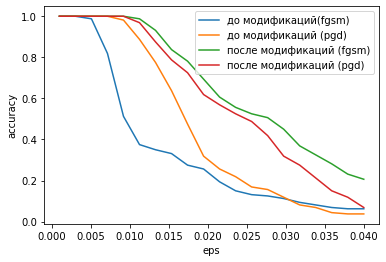

In [285]:
fig, ax = plt.subplots()
ax.plot(eps, [1.0, 1.0, 0.9875, 0.81875, 0.5125, 0.375, 0.35, 0.33125, 0.275, 0.25625, 0.19375001, 0.15, 0.13125001, 0.125, 0.112500004, 0.09375, 0.081250004, 0.06875, 0.0625, 0.0625], label='до модификаций(fgsm)')
ax.plot(eps, [1.0, 1.0, 1.0, 1.0, 0.98125, 0.8875, 0.77500004, 0.6375, 0.475, 0.31875, 0.25625, 0.21875, 0.16875, 0.15625, 0.11875, 0.081250004, 0.06875, 0.04375, 0.0375, 0.0375], label='до модификаций (pgd)')
ax.plot(eps, accuracy_fgsm_after_modification, label='после модификаций (fgsm)')
ax.plot(eps, accuracy_pgd_after_mod, label='после модификаций (pgd)')
ax.set_xlabel('eps')
ax.set_ylabel('accuracy')
ax.legend()
fig.patch.set_facecolor('white')
# plt.show()
plt.savefig("Обучение модели с pgd и fgsm (итог).png", dpi=300, bbox_inches='tight')

In [ ]:
accuracy_pgd_after_mod, accuracy_fgsm_after_modification

In [ ]:
accuracy_pgd

In [ ]:
eps, accuracy_fgsm[9], accuracy_fgsm_after_modification[9], 6/255

In [ ]:
def plot(x, y, label, xlabel="eps", ylabel="accuracy"):
    fig, ax = plt.subplots()
    ax.plot(x, y, label=label)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.legend()
    fig.patch.set_facecolor('white')
    # plt.show()
    # plt.savefig("FGSM_train_set.png", dpi=300, bbox_inches='tight')

In [ ]:
plot(eps, accuracy_fgsm, label="без модификаций")

In [ ]:
# modify train data with fgsm attack and retrain the model
x_adv = []
y_adv_true = []
# k = 6
k = 3
x_train_adv = attack(model, ProjectedGradientDescent(estimator=classifier, eps=0.03, max_iter=10), x_train[::k, :], y_train[::k, :])
y_adv_true.append(y_train[::k, :])
x_adv.append(x_train_adv)
x_train_adv = attack(model, FastGradientMethod(estimator=classifier, eps=0.03), x_train[::3, :], y_train[::3, :])
y_adv_true.append(y_train[::3, :])
x_adv.append(x_train_adv)
x_train_adv = attack(model, FastGradientMethod(estimator=classifier, eps=0.04), x_train[::4, :], y_train[::4, :])
y_adv_true.append(y_train[::4, :])
x_adv.append(x_train_adv)

In [ ]:
x_add_adv_data = np.array(x_train)
y_add_adv_data = np.array(y_train)
for i in range(len(x_adv)):
    x_add_adv_data = np.append(x_add_adv_data, x_adv[i]).reshape(-1, 62, 47, 1)
    y_add_adv_data = np.append(y_add_adv_data, y_adv_true[i]).reshape(-1, 5)

In [ ]:
# x_add_adv_data = np.append(x_train, x_train_adv).reshape(-1, 62, 47, 1)
# y_add_adv_data = np.append(y_train, y_train[::3, :]).reshape(-1, 5)
x_add_adv_data.shape, y_add_adv_data.shape

In [ ]:
model.fit(x_add_adv_data,y_add_adv_data, validation_data=(testx,testy),epochs=100, batch_size=32)

In [ ]:
model.fit(x_train, y_train, validation_data=(testx,testy), epochs=10, batch_size=64)

In [ ]:
accuracy_fgsm_after_modification = []
eps = np.linspace(1e-4, 0.04, 20)
for _eps in eps:
    x_adv = attack(model, FastGradientMethod(estimator=classifier, eps=_eps), x_train, y_train)
    loss, accuracy = model.evaluate(x_adv, y_train)
    accuracy_fgsm_after_modification.append(accuracy)

In [ ]:
fig, ax = plt.subplots()
ax.plot(eps, accuracy_fgsm, label='до модификаций')
ax.plot(eps, accuracy_fgsm_after_modification, label='после модификаций')
ax.set_xlabel('eps')
ax.set_ylabel('accuracy')
ax.legend()
fig.patch.set_facecolor('white')
# plt.show()
# plt.savefig("Обучение модели только с fgsm 0.03 [3].png", dpi=300, bbox_inches='tight')

In [ ]:
accuracy_fgsm[5], eps[5], accuracy_fgsm_after_modification[5]

In [ ]:
x_adv = attack(model, FastGradientMethod(estimator=classifier, eps=5/255), x_train, y_train)

In [282]:
x_adv = attack(model, attack_cw, x_train, y_train)

C&W L_inf:   0%|          | 0/160 [00:00<?, ?it/s]

2023-06-05 16:51:42.414561: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-05 16:51:42.700167: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-05 16:51:44.486721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-05 16:51:44.763359: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-05 16:51:46.532922: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


Accuracy on adversarial test examples: 71.25000357627869%


In [ ]:
x_adv = attack(model, attack_cw, x_train, y_train)

In [284]:
# model.save("VGG_model_87_adv_fgsm.pth")
# model = keras.models.load_model("VGG_model_87_adv_fgsm.pth")
# model.save("VGG_model_87_adv_pgd.pth")
# model = keras.models.load_model("VGG_model_87_adv_pgd.pth")
# model.save("VGG_model_87_adv_fgsm_pgd.pth")
# model = keras.models.load_model("VGG_model_87_adv_fgsm_pgd.pth")

2023-06-05 17:22:31.681512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-05 17:22:31.728003: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-06-05 17:22:31.772484: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


INFO:tensorflow:Assets written to: VGG_model_87_adv_fgsm_pgd.pth/assets


2023-06-05 17:22:32.512751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [ ]:
%load_ext tensorboard

In [ ]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Процесс генерации логов будет идти параллельно обучению, потому мы используем
# коллбэки.
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [ ]:
def plot_gallery(images, titles, h=62, w=47, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i+1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(Name[np.argmax(titles[i])], size=12)
        plt.xticks(())
        plt.yticks(())


def plot_image(image, title):
    """Helper function to plot a gallery of portraits"""
    plt.matshow(image, cmap=plt.cm.gray)
    plt.title(Name[np.argmax(title)], size=12)
    plt.xticks(())
    plt.yticks(())

In [ ]:
plot_gallery(x_adv, model.predict(x_adv))
# plt.savefig("Пример легко обнаруженных данных.png", dpi=300, bbox_inches='tight')

In [ ]:
plot_gallery(x_train, y_train)

In [ ]:
plot_image(x_train[5], y_train[5])
plt.savefig("PGD eps=6d255_clear.png", dpi=300, bbox_inches='tight')

In [ ]:
plot_image(x_adv[5], model.predict(x_adv)[5])
plt.savefig("PGD eps=6d255_adv.png", dpi=300, bbox_inches='tight')

In [391]:
import matplotlib.pyplot as plt
import numpy as np

def visualize_difference(original_image, adversarial_image):
    # Преобразование изображений в массивы NumPy
    original_array = np.squeeze(np.array(original_image))
    adversarial_array = np.squeeze(np.array(adversarial_image))

    # Вычисление разницы между исходным и вредоносным изображениями
    difference = original_array - adversarial_array
    n_difference = difference * 1
    n_difference = n_difference.reshape(62, 47, -1)

    # Создание подложки для графика
    fig, axs = plt.subplots(1, 3, figsize=(10, 5))

    # Отображение исходного изображения
    axs[0].imshow(original_array, cmap='gray')
    axs[0].set_title('Исходное изображение')

    # Отображение вредоносного изображения
    axs[1].imshow(adversarial_array, cmap='gray')
    axs[1].set_title('Вредоносное изображение')

    # Отображение разницы между исходным и вредоносным изображениями
    axs[2].imshow(n_difference, cmap='gray', vmax=np.max(n_difference), vmin=np.min(n_difference))
    axs[2].set_title('Разница')
    print(np.max(n_difference), np.max(original_array), np.max(adversarial_array))

    # Удаление осей
    for ax in axs:
        ax.axis('off')

    # Отображение графика
    plt.tight_layout()
    # plt.show()

In [397]:
visualize_difference(x_train[0], attack(model, CarliniLInfMethod(classifier=classifier, max_iter=5, learning_rate=0.01), x_train, y_train)[0])

C&W L_inf:   0%|          | 0/160 [00:00<?, ?it/s]

KeyboardInterrupt: 

C&W L_inf:   0%|          | 0/160 [00:00<?, ?it/s]

Accuracy on adversarial test examples: 100.0%
0.0 0.9895425 0.9895425


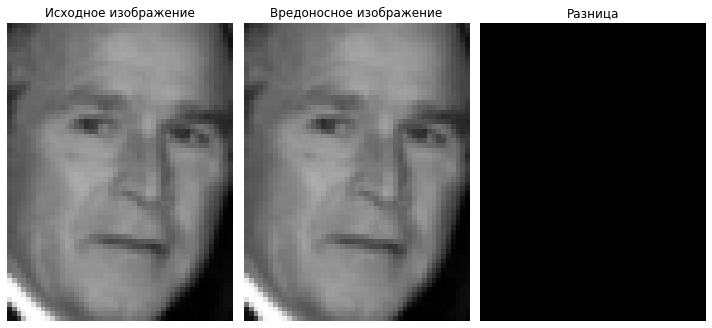

In [394]:
visualize_difference(x_train[0], attack(model, CarliniLInfMethod(classifier=classifier, max_iter=1,learning_rate=0.01), x_train, y_train)[0])

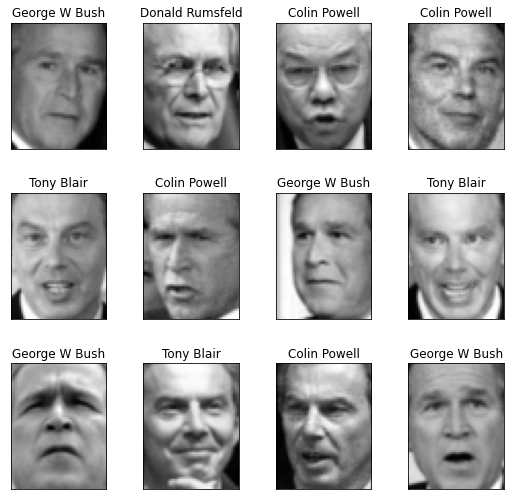

In [398]:
plot_gallery(x_adv, model.predict(x_adv))

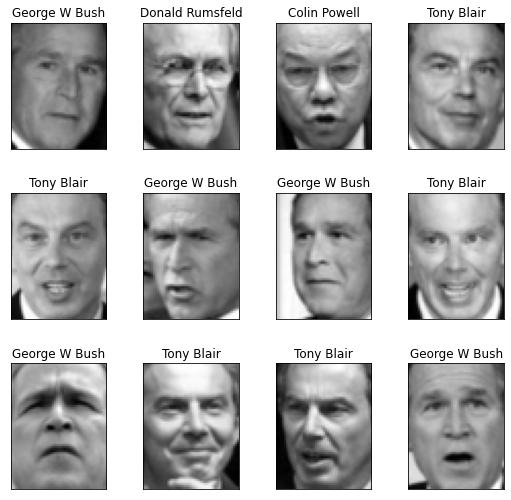